07-06-2018

**_Author: Dana Chermesh, Regional Planning intern_**


### US Metros comparison 
comparison by the county level of 15 regions (CSA's) accross the country

----

### _Notebook no.3_
# Housing 2010, 2016
### - _ACS 5-yesr estimates 2012-2016 using Census API_
### - _Decennial 2010 using Census API_
# Housing-Jobs balance
### - _BLS (cleaned on 3.1 notebook)_


----

A user guide for Census Data API:

# [Census Data API User Guide](https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf)

The Census Data API in an API that gives the public access to raw statistical data from various Census Bureau data
programs. In terms of space, we aggregate the data and usually associate them with a
certain Census geographic boundary/area defined by a FIPS code. 

## _get your API key from:_ 
https://api.census.gov/data/key_signup.html

**Recommended:** In order to keep your API key confidential, please save your API key in a .py file named **censusAPI.py** as follows:

```python
myAPI = 'XXXXXXXXXXXXXXX'
```
Then read into this notebook as in the following cell:
```python
from censusAPI import myAPI
```

### The complete list of all available datasets for the API is located here:
https://api.census.gov/data.html


----
# Housing units 2016
### _data were obtained from the  ACS 2012-2016 5-year estimate, all counties in the US_
variables to be acquired:
- **B25001_001E** |	Total Housing Units (occupied+vacant)
- **B25003_002E** | Owner occupied
- **B25003_003E** | Owner occupied

In [1]:
# imports for reading in, munging and calculating data
import pandas as pd
import json
import requests 
import urllib
import numpy as np

# reading in my api key saved in censusAPI.py as
# myAPI = 'XXXXXXXXXXXXXXX'
# request an api key in: https://api.census.gov/data/key_signup.html
from censusAPI import myAPI

# Python 3 compatibility
from __future__ import print_function, division

# Spatial
import geopandas as gpd
import fiona
import shapely

# Plotting
import matplotlib.pylab as pl
import seaborn as sns
sns.set_style('whitegrid')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs5/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [3]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

affkeys

array(['B24124_462E', 'B07013PR_006E', 'B17020H_014E', ...,
       'B17001A_019E', 'B25011_015E', 'B19001C_007E'], dtype='<U14')

In [4]:
# keyword for POP estimates
totalHU = 'B25001_001E'
owner = 'B25003_002E'
renter = 'B25003_003E'

aff1y['variables'][totalHU]

{'attributes': 'B25001_001M,B25001_001MA,B25001_001EA',
 'concept': 'HOUSING UNITS',
 'group': 'B25001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [5]:
# HU2016 data for all counties in the US
totalHU16 = pd.read_json('https://api.census.gov/data/2016/acs/acs5?get='+
                         totalHU + ',' +
                         owner + ',' +
                         renter +',NAME&for=county:*&in=state:*')
totalHU16.columns = totalHU16.iloc[0]
totalHU16 = totalHU16[1:]

totalHU16['state'] = totalHU16['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU16['county'] = totalHU16['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU16['STCO'] = totalHU16[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU16 = totalHU16.drop(['state', 'county'], axis=1)
totalHU16.columns = ['TotalHousing16', 'Owners16', 'renters16',
                     'Name', 'STCO']

print(totalHU16.shape)
totalHU16.head()

(3220, 5)


,TotalHousing16,Owners16,renters16,Name,STCO
1,22714,15218,5582,"Autauga County, Alabama",01001
2,107579,53905,21244,"Baldwin County, Alabama",01003
3,11802,5829,3293,"Barbour County, Alabama",01005
4,8972,5119,1929,"Bibb County, Alabama",01007
5,23850,16254,4365,"Blount County, Alabama",01009


##  Reading in geo-coded dataset
created on a different notebook, please refer to _**ADD NOTEBOOK NAME**_

In [21]:
geo = pd.read_csv('../Regional_USmetros_comparison/data/USmetros_full.csv').iloc[:,:-2] \
                                .drop(['Unnamed: 0', 'SHAPE_AREA'], axis=1)
geo['STCO'] = geo['STCO'].apply(lambda x: '{0:0>5}'.format(x))

print(geo.shape)
geo.head()

(270, 4)


,CSA,CSA_name,County_name,STCO
0,488,"San Jose-San Francisco-Oakland, CA",Alameda,06001
1,488,"San Jose-San Francisco-Oakland, CA",Contra Costa,06013
2,488,"San Jose-San Francisco-Oakland, CA",Marin,06041
3,488,"San Jose-San Francisco-Oakland, CA",Napa,06055
4,488,"San Jose-San Francisco-Oakland, CA",San Benito,06069


In [33]:
STCO = list(geo['STCO'])

print(type(STCO))
print(len(STCO))
STCO[:5]

<class 'list'>
270


['06001', '06013', '06041', '06055', '06069']

In [34]:
STCOstr = ",".join(STCO)
STCOstr

'06001,06013,06041,06055,06069,06075,06077,06081,06085,06087,06095,06097,06037,06059,08001,08005,08013,08014,08019,08031,08035,08039,08047,08059,08093,08123,09001,09005,09009,34003,34013,34017,34019,34021,34023,34025,34027,34029,34031,34035,34037,34039,34041,36005,36027,36047,36059,36061,36071,36079,36081,36085,36087,36103,36111,36119,09015,25001,25005,25009,25017,25021,25023,25025,25027,33001,33011,33013,33015,33017,44001,44003,44005,44007,44009,10001,10003,24015,34001,34005,34007,34009,34011,34015,34033,42011,42017,42029,42045,42091,42101,11001,24003,24005,24009,24013,24017,24019,24021,24025,24027,24031,24033,24035,24037,24041,24043,24510,42055,51013,51043,51047,51059,51061,51069,51107,51153,51157,51177,51179,51187,51510,51600,51610,51630,51683,51685,51840,54003,54027,54037,12011,12061,12085,12086,12093,12099,12111,13013,13015,13035,13045,13057,13059,13063,13067,13077,13085,13089,13097,13113,13117,13121,13129,13135,13139,13143,13149,13151,13157,13159,13171,13195,13199,13211,13217,132

### Merging datasets

In [7]:
HOUSING16_CO = totalHU16.merge(geo, on='STCO').set_index('County_name')

print(HOUSING16_CO.shape)
HOUSING16_CO.head()

(270, 7)


,TotalHousing16,Owners16,renters16,Name,STCO,CSA,CSA_name
County_name,,,,,,,
Alameda,592796,296634,267659,"Alameda County, California",06001,488,"San Jose-San Francisco-Oakland, CA"
Contra Costa,406803,250055,137485,"Contra Costa County, California",06013,488,"San Jose-San Francisco-Oakland, CA"
Los Angeles,3490118,1499576,1782269,"Los Angeles County, California",06037,348,"Los Angeles-Long Beach, CA"
Marin,112259,66200,38200,"Marin County, California",06041,488,"San Jose-San Francisco-Oakland, CA"
Napa,55301,30411,18964,"Napa County, California",06055,488,"San Jose-San Francisco-Oakland, CA"


In [8]:
HOUSING16_CO[HOUSING16_CO['CSA']==408].shape

(31, 7)

In [9]:
# convert numeric columns from str ('object') to int via to_numeric
HOUSING16_CO.iloc[:,:3] = HOUSING16_CO.iloc[:,:3].apply(pd.to_numeric,
                                                      errors='coerce')

HOUSING16_CO.dtypes

TotalHousing16     int64
Owners16           int64
renters16          int64
Name              object
STCO              object
CSA                int64
CSA_name          object
dtype: object

### Exporting all counties Housing data to .csv

In [15]:
HOUSING16_CO.to_csv('HOUSING16_CO.csv')

## Groupby CSAs to sum

In [10]:
CSA_housing16 = HOUSING16_CO.groupby(['CSA', 'CSA_name']).sum()

print(CSA_housing16.shape)
CSA_housing16

(15, 3)


,,TotalHousing16,Owners16,renters16
CSA,CSA_name,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",2475969,1396394,824382
148,"Boston-Worcester-Providence, MA-RI-NH-CT",3412143,1934972,1151423
176,"Chicago-Naperville, IL-IN-WI",1792036,1222063,435630
206,"Dallas-Fort Worth, TX-OK",2832798,1566020,1034702
216,"Denver-Aurora, CO",1350238,814383,464369
220,"Detroit-Warren-Ann Arbor, MI",2340603,1420760,652609
288,"Houston-The Woodlands, TX",2534512,1383407,907205
348,"Los Angeles-Long Beach, CA",4562239,2081082,2217775
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",2809034,1419029,888587


### Exporting CSA's Housing data to .csv

In [19]:
CSA_housing16.to_csv('HOUSING16_CSAs.csv')

----

# Housing units 2010
### _data were obtained from the ACS 2006-2010 5-year estimate, all counties in the US_
variables to be acquired:
- **B25002_001E** |	Total Housing Units (occupied + vacant)
- **B25003_002E** | Owner occupied
- **B25003_003E** | Renter occupied

In [101]:
url10 = "https://api.census.gov/data/2010/acs/acs5/variables.json"
resp10 = requests.request('GET', url10)
aff1y10 = json.loads(resp10.text)

In [102]:
#turning things into arrays to enable broadcasting
#Python3
affkeys10 = np.array(list(aff1y10['variables'].keys()))

affkeys10

array(['B24124_462E', 'B24032_034E', 'B25073_024E', ..., 'B25011_015E',
       'B08532_010E', 'B19001C_007E'], dtype='<U14')

In [103]:
# keyword for POP estimates
totalHU10 = 'B25002_001E'
owner10 = 'B25003_002E'
renter10 = 'B25003_003E'

aff1y10['variables'][totalHU10]

{'attributes': 'B25002_001EA,B25002_001M,B25002_001MA',
 'group': 'B25002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [105]:
# HU2010 data for all counties in the US
totalHU10 = pd.read_json('https://api.census.gov/data/2010/acs/acs5?get='+
                         totalHU10 + ',' +
                         owner10 + ',' +
                         renter10 +',NAME&for=county:*&in=state:*')
totalHU10.columns = totalHU10.iloc[0]
totalHU10 = totalHU10[1:]

totalHU10['state'] = totalHU10['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10['county'] = totalHU10['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10['STCO'] = totalHU10[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10.iloc[:,:3] = totalHU10.iloc[:,:3].apply(pd.to_numeric,
                                                 errors='coerce')

totalHU10 = totalHU10.drop(['state', 'county'], axis=1)
totalHU10.columns = ['TotalHousing10', 'Owners10', 'renters10',
                     'Name', 'STCO']

print(totalHU10.shape)
totalHU10.head()

(3221, 5)


,TotalHousing10,Owners10,renters10,Name,STCO
1,83089,41135,32451,"Merced County, California",06047
2,5133,2790,1187,"Modoc County, California",06049
3,13802,2978,2305,"Mono County, California",06051
4,138833,66731,58232,"Monterey County, California",06053
5,54306,31996,17183,"Napa County, California",06055


In [106]:
totalHU10.dtypes

TotalHousing10    object
Owners10          object
renters10         object
Name              object
STCO              object
dtype: object

In [107]:
totalHU10 = totalHU10.merge(geo, on='STCO').set_index('County_name')

print(totalHU10.shape)
totalHU10.head()

(270, 7)


,TotalHousing10,Owners10,renters10,Name,STCO,CSA,CSA_name
County_name,,,,,,,
Napa,54306,31996,17183,"Napa County, California",06055,488,"San Jose-San Francisco-Oakland, CA"
Orange,1042254,599032,385471,"Orange County, California",06059,348,"Los Angeles-Long Beach, CA"
San Benito,17873,10807,6005,"San Benito County, California",06069,488,"San Jose-San Francisco-Oakland, CA"
San Francisco,372560,126028,209928,"San Francisco County, California",06075,488,"San Jose-San Francisco-Oakland, CA"
San Joaquin,231114,131357,81548,"San Joaquin County, California",06077,488,"San Jose-San Francisco-Oakland, CA"


In [108]:
# export to .csv
totalHU10.to_csv('exports/HOUSING10_CO.csv')

In [109]:
totalHU10[['TotalHousing10','renters10', 'Owners10']] = totalHU10[['TotalHousing10',
                                                        'renters10', 'Owners10']].apply(pd.to_numeric,
                                                                                    errors='coerce')

In [110]:
totalHU10.dtypes

TotalHousing10     int64
Owners10           int64
renters10          int64
Name              object
STCO              object
CSA                int64
CSA_name          object
dtype: object

In [111]:
CSA_housing10 = totalHU10.groupby(['CSA', 'CSA_name']).sum()

print(CSA_housing10.shape)
CSA_housing10

(15, 3)


,,TotalHousing10,Owners10,renters10
CSA,CSA_name,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",2385537,1419824,677107
148,"Boston-Worcester-Providence, MA-RI-NH-CT",3352133,1964962,1066964
176,"Chicago-Naperville, IL-IN-WI",1761685,1261908,371183
206,"Dallas-Fort Worth, TX-OK",2637717,1509869,866058
216,"Denver-Aurora, CO",1282906,787841,395363
220,"Detroit-Warren-Ann Arbor, MI",2336269,1504995,561392
288,"Houston-The Woodlands, TX",2299533,1284443,739694
348,"Los Angeles-Long Beach, CA",4467990,2151123,2051269
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",2749614,1509088,744024


In [114]:
CSA_housing = CSA_housing10.merge(CSA_housing16, left_index=True,
                                                 right_index=True)

CSA_housing['HousingNET'] = CSA_housing['TotalHousing16']-CSA_housing['TotalHousing10']
CSA_housing['OwnersNET'] = CSA_housing['Owners16']-CSA_housing['Owners10'] 
CSA_housing['RentersNET'] = CSA_housing['renters16']-CSA_housing['renters10'] 

CSA_housing

,,TotalHousing10,Owners10,renters10,TotalHousing16,Owners16,renters16,HousingNET,OwnersNET,RentersNET
CSA,CSA_name,,,,,,,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",2385537,1419824,677107,2475969,1396394,824382,90432,-23430,147275
148,"Boston-Worcester-Providence, MA-RI-NH-CT",3352133,1964962,1066964,3412143,1934972,1151423,60010,-29990,84459
176,"Chicago-Naperville, IL-IN-WI",1761685,1261908,371183,1792036,1222063,435630,30351,-39845,64447
206,"Dallas-Fort Worth, TX-OK",2637717,1509869,866058,2832798,1566020,1034702,195081,56151,168644
216,"Denver-Aurora, CO",1282906,787841,395363,1350238,814383,464369,67332,26542,69006
220,"Detroit-Warren-Ann Arbor, MI",2336269,1504995,561392,2340603,1420760,652609,4334,-84235,91217
288,"Houston-The Woodlands, TX",2299533,1284443,739694,2534512,1383407,907205,234979,98964,167511
348,"Los Angeles-Long Beach, CA",4467990,2151123,2051269,4562239,2081082,2217775,94249,-70041,166506
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",2749614,1509088,744024,2809034,1419029,888587,59420,-90059,144563


In [115]:
# export to .csv
CSA_housing.to_csv('exports/CSA_housing10-16.csv')

----

# Housing / Jobs Balance analysis

- PEP/2017/housing
- BLS QCEW 2017 annually

# 1. Counties - for mapping

## Total Employement 
- 'annual_avg_emplvl'

In [50]:
Jobs17 = pd.read_csv('JobsCO17')

Jobs17['STCO'] = Jobs17['STCO'].astype(str)
Jobs17['STCO'] = Jobs17['STCO'].apply(lambda x: '{0:0>5}'.format(x))

print(Jobs17.shape)
Jobs17.head()

(270, 2)


,STCO,Total_emp17
0,06001,772071
1,06013,366799
2,06041,115421
3,06055,76765
4,06069,16977


## Total Housing from PEP housing 2017
- [examples for /data/2017/pep/housing](https://api.census.gov/data/2017/pep/housing/examples.html)

In [131]:
# HU2017 data for all counties in the US
totalHU17 = pd.read_json('https://api.census.gov/data/2017/pep/housing?get='+
                         'HUEST,GEONAME&for=county:*&DATE=')

totalHU17.columns = totalHU17.iloc[0]
totalHU17 = totalHU17[1:]

totalHU17['state'] = totalHU17['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU17['county'] = totalHU17['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU17['STCO'] = totalHU17[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU17 = totalHU17.drop(['state', 'county','DATE'], axis=1)
totalHU17.columns = ['TotalHousing17','Name', 'STCO']

print(totalHU17.shape)
totalHU17.head(20)

(31420, 3)


,TotalHousing17,Name,STCO
1,361221,"Fairfield County, Connecticut",09001
2,361227,"Fairfield County, Connecticut",09001
3,361473,"Fairfield County, Connecticut",09001
4,362217,"Fairfield County, Connecticut",09001
5,362977,"Fairfield County, Connecticut",09001
6,364917,"Fairfield County, Connecticut",09001
7,367207,"Fairfield County, Connecticut",09001
8,368888,"Fairfield County, Connecticut",09001
9,371270,"Fairfield County, Connecticut",09001
10,372981,"Fairfield County, Connecticut",09001


In [ ]:
# HU2010 data for all counties in the US
totalHU10 = pd.read_json('https://api.census.gov/data/2010/pep/housing?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU17.columns = totalHU17.iloc[0]
totalHU17 = totalHU17[1:]

totalHU17['state'] = totalHU17['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU17['county'] = totalHU17['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU17['STCO'] = totalHU17[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU17 = totalHU17.drop(['state', 'county','DATE'], axis=1)
totalHU17.columns = ['TotalHousing17','Name', 'STCO']

print(totalHU17.shape)
totalHU17.head()

### Merging with geo

In [52]:
HOUSING17_CO = totalHU17.merge(geo, on='STCO').set_index('County_name')

HOUSING17_CO = HOUSING17_CO.drop('Name', axis=1)

print(HOUSING17_CO.shape)
HOUSING17_CO.head()

(270, 4)


,TotalHousing17,STCO,CSA,CSA_name
County_name,,,,
Fairfield,372981,09001,408,"New York-Newark, NY-NJ-CT-PA"
Litchfield,88285,09005,408,"New York-Newark, NY-NJ-CT-PA"
New Haven,367195,09009,408,"New York-Newark, NY-NJ-CT-PA"
Windham,49742,09015,148,"Boston-Worcester-Providence, MA-RI-NH-CT"
Barnstable,163533,25001,148,"Boston-Worcester-Providence, MA-RI-NH-CT"


In [53]:
HOUSING17_CO.dtypes

TotalHousing17    object
STCO              object
CSA                int64
CSA_name          object
dtype: object

## Merging with Jobs data

In [135]:
HouJobs17 = HOUSING17_CO.merge(Jobs17, on='STCO')

HouJobs17 = HouJobs17.drop('CSA_name', axis=1)
HouJobs17['TotalHousing17'] = HouJobs17['TotalHousing17'].astype(int)
HouJobs17['CSA'] = HouJobs17['CSA'].astype(str)

HouJobs17 = HouJobs17.append(HouJobs17.sum(numeric_only=True), ignore_index=True)
HouJobs17['TotalHousing17'] = HouJobs17['TotalHousing17'].astype(int)
HouJobs17['Total_emp17'] = HouJobs17['Total_emp17'].astype(int)

HouJobs17['housing/jobs2017'] = HouJobs17['TotalHousing17'] / HouJobs17['Total_emp17']

print(HouJobs17.shape)
HouJobs17.head()

(271, 5)


,TotalHousing17,STCO,CSA,Total_emp17,housing/jobs2017
0,372981,09001,408,419998,0.888054
1,88285,09005,408,60508,1.459063
2,367195,09009,408,364067,1.008592
3,49742,09015,148,38776,1.282804
4,163533,25001,148,97180,1.682785


In [136]:
HouJobs17.tail()

,TotalHousing17,STCO,CSA,Total_emp17,housing/jobs2017
266,346026,53053,500,302424,1.144175
267,53800,53057,500,50708,1.060977
268,310084,53061,500,283946,1.092053
269,116820,53067,500,113258,1.031450
270,47591227,NaN,NaN,55246257,0.861438


In [137]:
HouJobs17['fromAve'] = HouJobs17['housing/jobs2017'] - 0.861438
HouJobs17.tail()

,TotalHousing17,STCO,CSA,Total_emp17,housing/jobs2017,fromAve
266,346026,53053,500,302424,1.144175,2.827371e-01
267,53800,53057,500,50708,1.060977,1.995386e-01
268,310084,53061,500,283946,1.092053,2.306147e-01
269,116820,53067,500,113258,1.031450,1.700123e-01
270,47591227,NaN,NaN,55246257,0.861438,3.371150e-08


In [144]:
0.861438- 0.861438

0.0

## Reading in Geopgraphies df
Created through notebook #0: **US_Metro_Comparison_Geographies**

- **_Make sure to import GEOPANDAS_**

In [72]:
GEO = gpd.GeoDataFrame.from_file('USmetros_rawNYC.shp')

GEO['STCO'] = GEO['STCO'].astype(str)
GEO['STCO'] = GEO['STCO'].apply(lambda x: '{0:0>5}'.format(x))

GEO['CSA_short'] = GEO['CSA_name'].str.split('-').str[0]
GEO['CSA_short'] = GEO['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(type(GEO))
print(GEO.shape)
print(GEO.geometry.name)
GEO.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(274, 7)
geometry


,SHAPE_AREA,STCO,County_nam,CSA,CSA_name,geometry,CSA_short
0,3.124167e+09,06001,Alameda,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco
1,3.158013e+09,06013,Contra Costa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco
2,2.298070e+09,06041,Marin,488,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco
3,3.344885e+09,06055,Napa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco
4,5.596080e+09,06069,San Benito,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco


## Merging Housing-Jobs data with .shp

In [140]:
HouJobs17_geo = GEO.merge(HouJobs17, on='STCO')

HouJobs17_geo = HouJobs17_geo.drop('CSA_y', axis=1)
HouJobs17_geo.rename(columns={'CSA_x':'CSA'}, inplace=True)
HouJobs17_geo = HouJobs17_geo.set_index('CSA')

print(type(HouJobs17_geo))
print(HouJobs17_geo.shape)
print(HouJobs17_geo.geometry.name)
HouJobs17_geo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(269, 10)
geometry


,SHAPE_AREA,STCO,County_nam,CSA_name,geometry,CSA_short,TotalHousing17,Total_emp17,housing/jobs2017,fromAve
CSA,,,,,,,,,,
488,3.124167e+09,06001,Alameda,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco,606052,772071,0.784969,-0.076469
488,3.158013e+09,06013,Contra Costa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco,414007,366799,1.128703,0.267265
488,2.298070e+09,06041,Marin,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco,113126,115421,0.980116,0.118678
488,3.344885e+09,06055,Napa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco,55847,76765,0.727506,-0.133932
488,5.596080e+09,06069,San Benito,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco,18876,16977,1.111857,0.250419


In [81]:
CSAs = HouJobs17_geo.groupby(['CSA', 'CSA_name']).count().reset_index().set_index('CSA')
CSAs = CSAs.iloc[:,:2]
CSAs.columns = ['CSA_name', 'numberCounties']

CSAs['CSA_short'] = CSAs['CSA_name'].str.split('-').str[0]
CSAs['CSA_short'] = CSAs['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(CSAs.index)
print(CSAs.shape)
CSAs

Index(['122', '148', '176', '206', '216', '220', '288', '348', '370', '378',
       '408', '428', '488', '500', '548'],
      dtype='object', name='CSA')
(15, 3)


,CSA_name,numberCounties,CSA_short
CSA,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",39,Atlanta
148,"Boston-Worcester-Providence, MA-RI-NH-CT",19,Boston
176,"Chicago-Naperville, IL-IN-WI",18,Chicago
206,"Dallas-Fort Worth, TX-OK",20,Dallas
216,"Denver-Aurora, CO",12,Denver
220,"Detroit-Warren-Ann Arbor, MI",10,Detroit
288,"Houston-The Woodlands, TX",14,Houston
348,"Los Angeles-Long Beach, CA",2,Los Angeles
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",7,Miami


In [158]:
CSAs_sorted = ['500','216', '220','378','148',
               '488','176',  '122','548','408',
               '348', '206', '288', '428', '370']

## Plotting Housing-Jobs Balance for all CSA's - county level
- 2010
- 2017
- change 10-17

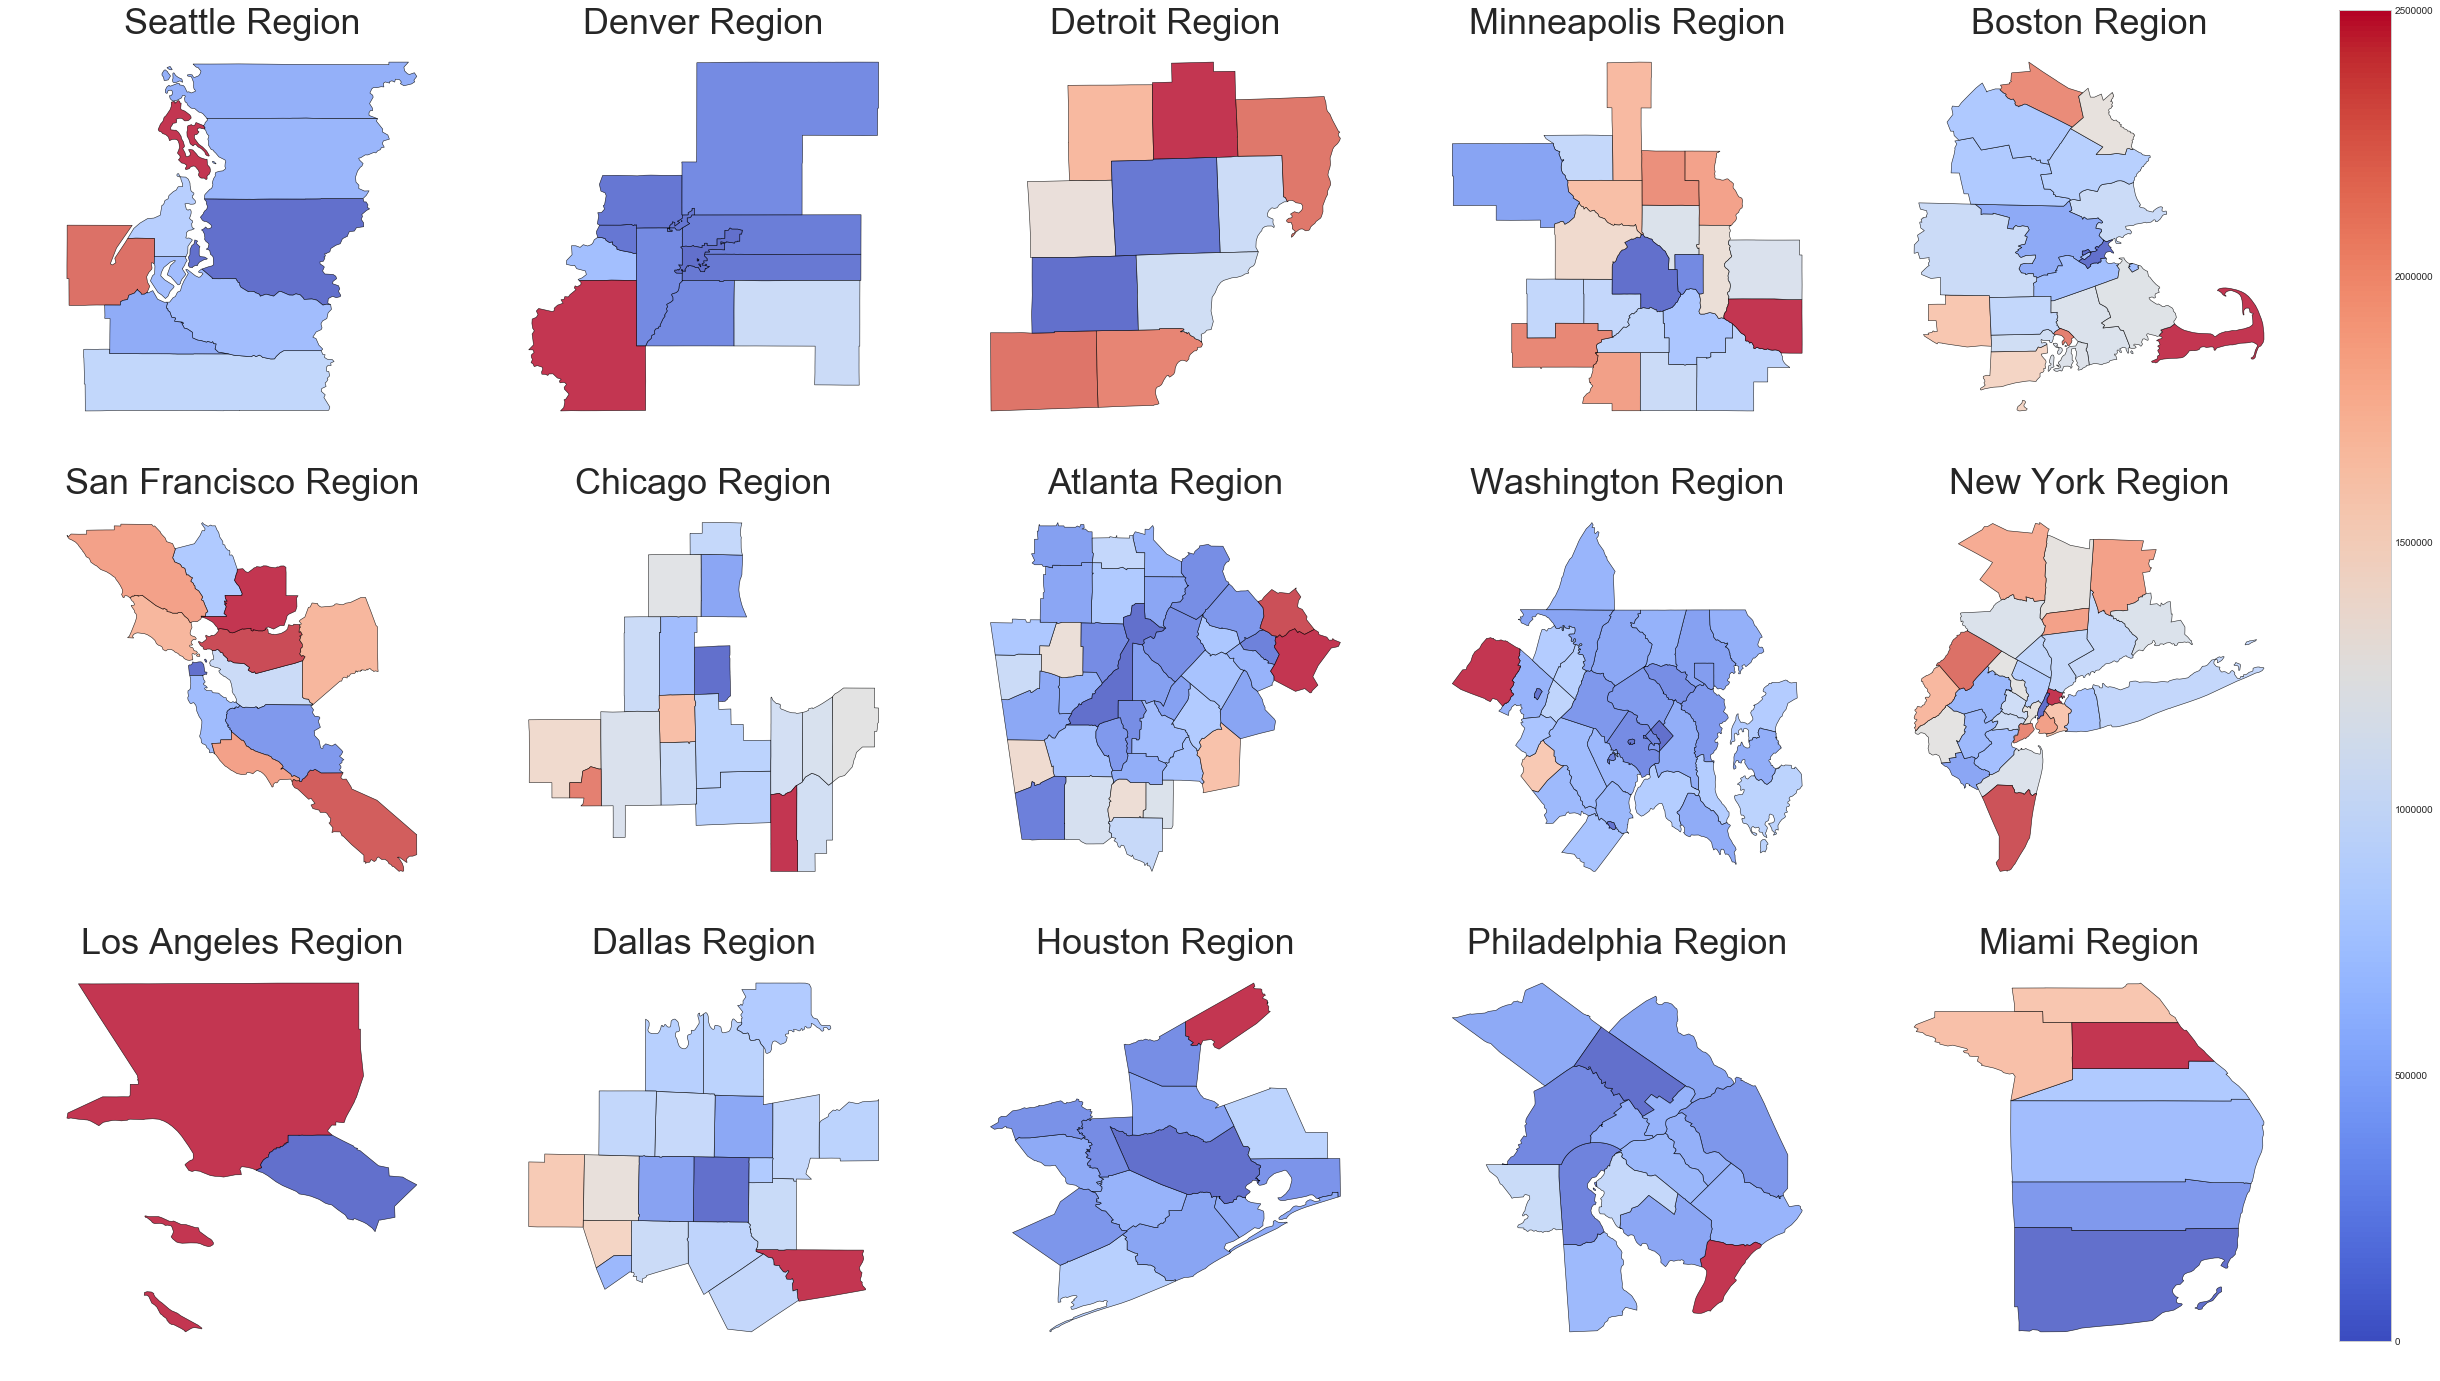

In [161]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 2500000

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    HouJobs17_geo[HouJobs17_geo.index == CSAs_sorted[k]].plot(ax=ax, column='fromAve',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/HouJobs17.pdf", transparent=True)

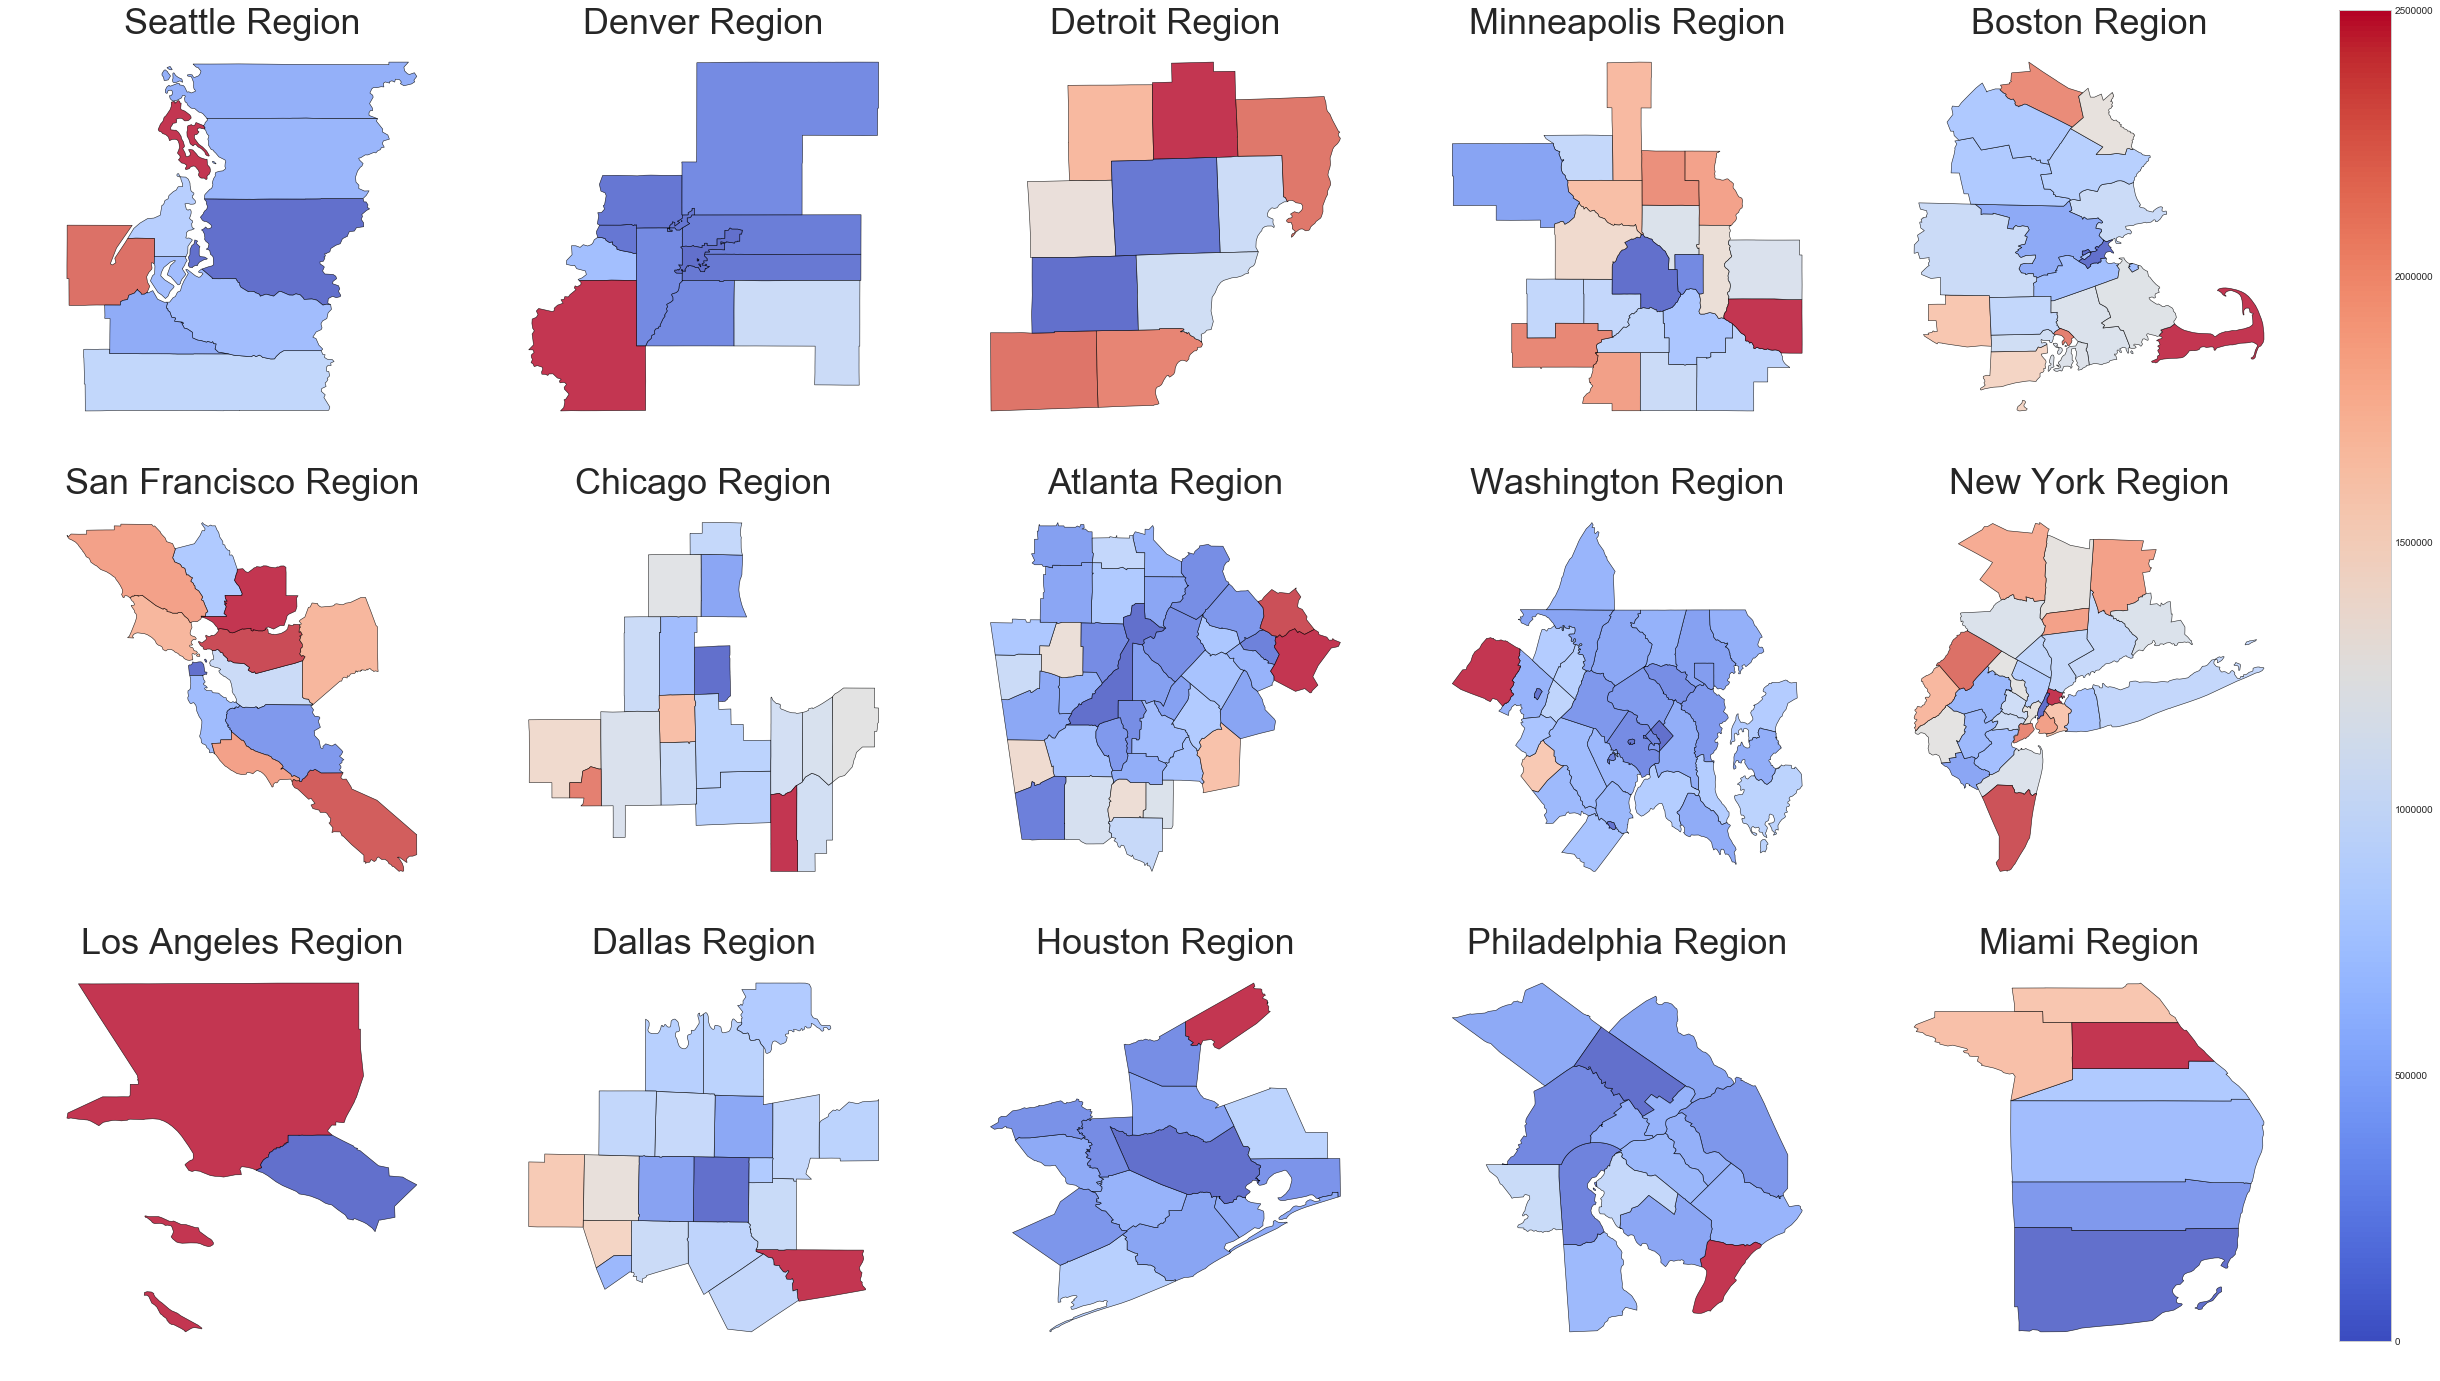

In [162]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 2500000

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    HouJobs17_geo[HouJobs17_geo.index == CSAs_sorted[k]].plot(ax=ax, column='housing/jobs2017',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/HouJobs17_1.pdf", transparent=True)

------

## CSA's

In [66]:
HouJobs = pd.read_excel('BPS_HousingPermits_analysis.xlsx', 
                        sheet_name='HousingJobs_Balance')[:-2].set_index('Name')

HouJobs['housing / jobs 2010'] = HouJobs['housing / jobs 2010'].round(decimals=2)
HouJobs['housing / jobs 2016'] = HouJobs['housing / jobs 2016'].round(decimals=2)
HouJobs['housing / jobs 10-16 NET'] = HouJobs['housing / jobs 10-16 NET'].round(decimals=2)

HouJobs['CSA'] = HouJobs['CSA'].astype(int)

print(HouJobs .shape)
HouJobs 

(15, 5)


,CSA,FullName,housing / jobs 2010,housing / jobs 2016,housing / jobs 10-16 NET
Name,,,,,
New York,408,"New York-Newark, NY-NJ-CT-PA",0.92,0.84,-0.07
Los Angeles,348,"Los Angeles-Long Beach, CA",0.68,0.60,-0.08
Chicago,176,"Chicago-Naperville, IL-IN-WI",0.42,0.39,-0.03
Washington,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",0.84,0.80,-0.04
San Francisco,488,"San Jose-San Francisco-Oakland, CA",0.92,0.77,-0.14
Boston,148,"Boston-Worcester-Providence, MA-RI-NH-CT",0.92,0.84,-0.08
Dallas,206,"Dallas-Fort Worth, TX-OK",0.92,0.81,-0.11
Philadelphia,428,"Philadelphia-Reading-Camden, PA-NJ-DE-MD",0.97,0.93,-0.04
Houston,288,"Houston-The Woodlands, TX",0.94,0.86,-0.08
